# Notes

Third iteration is to model: To use the best model architecture and add feature engineering with rebase


In [1]:
import os 
import re
import csv
import json
import math
from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# Constants

In [2]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [3]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'exercises_raw')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'exercises_test')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'exercises_augmented')
dir_patiens_sessions = os.path.join(dir_data_root, 'json', 'patients_sessions')

# Data prep

### Build training set

In [4]:
all_regions = json.load(open(os.path.join('.', 'settings', 'all_regions.json')))

all_regions

['frontal', 'orbital', 'oral']

In [5]:
regions = json.load(open(os.path.join('.', 'settings', 'pois_region.json')))

regions

{'0_LefteyeMidbottom': 'orbital',
 '1_LefteyeMidtop': 'orbital',
 '2_LefteyeInnercorner': 'orbital',
 '3_LefteyeOutercorner': 'orbital',
 '4_LefteyebrowInner': 'frontal',
 '5_LefteyebrowCenter': 'frontal',
 '6_RighteyeMidbottom': 'orbital',
 '7_RighteyeMidtop': 'orbital',
 '8_RighteyeInnercorner': 'orbital',
 '9_RighteyeOutercorner': 'orbital',
 '10_RighteyebrowInner': 'frontal',
 '11_RighteyebrowCenter': 'frontal',
 '12_NoseTip': 'frontal',
 '13_MouthLowerlipMidbottom': 'oral',
 '14_MouthLeftcorner': 'oral',
 '15_MouthRightcorner': 'oral',
 '16_MouthUpperlipMidtop': 'oral',
 '17_ChinCenter': 'oral',
 '18_ForeheadCenter': 'frontal',
 '19_LeftcheekCenter': 'oral',
 '20_RightcheekCenter': 'oral'}

In [6]:
bases = json.load(open(os.path.join('.', 'settings', 'pois_base.json')))

bases

{'0_LefteyeMidbottom': '18_ForeheadCenter',
 '1_LefteyeMidtop': '18_ForeheadCenter',
 '2_LefteyeInnercorner': '18_ForeheadCenter',
 '3_LefteyeOutercorner': '18_ForeheadCenter',
 '4_LefteyebrowInner': '18_ForeheadCenter',
 '5_LefteyebrowCenter': '18_ForeheadCenter',
 '6_RighteyeMidbottom': '18_ForeheadCenter',
 '7_RighteyeMidtop': '18_ForeheadCenter',
 '8_RighteyeInnercorner': '18_ForeheadCenter',
 '9_RighteyeOutercorner': '18_ForeheadCenter',
 '10_RighteyebrowInner': '18_ForeheadCenter',
 '11_RighteyebrowCenter': '18_ForeheadCenter',
 '12_NoseTip': '18_ForeheadCenter',
 '13_MouthLowerlipMidbottom': '18_ForeheadCenter',
 '14_MouthLeftcorner': '18_ForeheadCenter',
 '15_MouthRightcorner': '18_ForeheadCenter',
 '16_MouthUpperlipMidtop': '18_ForeheadCenter',
 '17_ChinCenter': '18_ForeheadCenter',
 '18_ForeheadCenter': '18_ForeheadCenter',
 '19_LeftcheekCenter': '18_ForeheadCenter',
 '20_RightcheekCenter': '18_ForeheadCenter'}

#### Feature engineering

In [7]:
def rescale(value, minimum, maximum):
    return (value - minimum) / (maximum - minimum)

def normalise(s):
    s_minimum = min(s)
    s_maximum = max(s)
    
    if (s_maximum - s_minimum) == 0:
        return s
    
    return [rescale(x, s_minimum, s_maximum) for x in s]

In [8]:
def unit_vector(vector):
    if np.linalg.norm(vector) == 0:
        return np.nan
    
    return vector / np.linalg.norm(vector)

def angle_between_two_points(p1, p2):
    p1_u = unit_vector(p1)
    p2_u = unit_vector(p2)
    result = np.arccos(np.clip(np.dot(p1_u, p2_u), -1.0, 1.0))
    return 0.0 if np.isnan(result) else result

def direction_angles(xs, ys, zs):
    angles = [0]
    for i in range(1, len(xs)):
        angles.append(angle_between_two_points([xs[i-1], ys[i-1], zs[i-1]], [xs[i], ys[i], zs[i]]))
        
    return angles

In [9]:
def normalize_by_start(s):
    return [x - s[0] for x in s]

In [10]:
def distance(xs, ys, zs):
    distance = [0]
    for i in range(1, len(xs)):
        distance.append(math.dist([xs[i-1], ys[i-1], zs[i-1]], [xs[i], ys[i], zs[i]]))
    
    return distance

In [11]:
def rebase(s, s_name, poi_name, pois, bases):
    base_name = bases[poi_name]
    base_s = pois[base_name][s_name]
    return[x - bx for x, bx in zip(s, base_s)]

In [12]:
def feature_engineering_sequence(poi, re_base=False, poi_name='', pois={}):
    new_sequences = []    
    if re_base:
        xs = rebase(poi['xs'], 'xs', poi_name, pois, bases)
        ys = rebase(poi['ys'], 'ys', poi_name, pois, bases)
        zs = rebase(poi['zs'], 'zs', poi_name, pois, bases)
    else:
        xs = poi['xs']
        ys = poi['ys']
        zs = poi['zs']
        
    #original
    new_sequences.append(xs)
    new_sequences.append(ys)
    new_sequences.append(zs)
    #normalize by start
    #new_sequences.append(normalize_by_start(xs)) 
    #new_sequences.append(normalize_by_start(ys))
    #new_sequences.append(normalize_by_start(zs))
    #normalize
    #new_sequences.append(normalise(xs)) 
    #new_sequences.append(normalise(ys))
    #new_sequences.append(normalise(zs))
    #direction
    new_sequences.append(direction_angles(xs, ys, zs))
    #distance
    new_sequences.append(distance(xs, ys, zs))
    
    return new_sequences

In [13]:
def build_region(pois, region):
    exercise_sequence_region = []
    
    for poi_name in sorted(pois.keys()):
        if regions[poi_name] == region or region == 'global':
            sequences = pois[poi_name]
            
            exercise_sequence_region.extend(feature_engineering_sequence(sequences))
            exercise_sequence_region.extend(feature_engineering_sequence(sequences, True, poi_name, pois))
            
    exercise_sequence_region = pad_sequences(
        exercise_sequence_region,
        padding="pre",
        maxlen=SEQ_MAX_LEN)
        
    return exercise_sequence_region

In [14]:
def exercise_to_input(file_path):
    exercise = json.load(open(file_path, 'r'))

    # build regions 
    exercise_sequence_global_region = build_region(exercise['pois'], 'global')
    exercise_sequence_frontal_region = build_region(exercise['pois'], 'frontal')
    exercise_sequence_oral_region = build_region(exercise['pois'], 'oral')
    exercise_sequence_orbital_region = build_region(exercise['pois'], 'orbital')
        
    # build meta
    x_a_1 = [0] * NUM_EXERCISES
    x_a_2 = [0] * NUM_FLAG_BS
    x_a_1[exercise['meta']['id']] = 1
    x_a_2[exercise['meta']['flag_before_surgery']] = 1

    return [
            x_a_1 + x_a_2, 
            exercise_sequence_global_region, 
            exercise_sequence_frontal_region,
            exercise_sequence_oral_region,
            exercise_sequence_orbital_region,
            exercise['meta']['evaluation']
           ]

In [29]:
xslist_meta = list()
xslist_global = list()
xslist_frontal = list()
xslist_oral = list()
xslist_orbital = list()
yslist = list()

exercises_sources = [
    #dir_exercises_test
    dir_exercises,
    dir_exercises_augmented
]

for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue

        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path)

        yslist.append(_ys)
        xslist_meta.append(_xs_meta)  
        xslist_global.append(_xs_global)
        xslist_frontal.append(_xs_frontal)
        xslist_oral.append(_xs_oral)
        xslist_orbital.append(_xs_orbital)
            
ys = np.array(yslist)
xs_meta = np.array(xslist_meta)   
xs_global = np.array(xslist_global) 
xs_frontal = np.array(xslist_frontal) 
xs_oral = np.array(xslist_oral) 
xs_orbital = np.array(xslist_orbital) 

print(ys.shape)
print(xs_meta.shape)
print(xs_global.shape)
print(xs_frontal.shape)
print(xs_oral.shape)
print(xs_orbital.shape)

(10740,)
(10740, 11)
(10740, 210, 600)
(10740, 60, 600)
(10740, 70, 600)
(10740, 80, 600)


## Modeling

In [30]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [31]:
def get_dnn(inputLayer): 
    m = Dense(4, activation="relu")(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [32]:
def get_cnn(inputLayer):
    chanDim = -1
    
    m = Conv1D(16, 3, padding='same', activation='relu')(inputLayer)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Conv1D(32, 3, padding='same', activation='relu')(m)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Conv1D(64, 3, padding='same', activation='relu')(m)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Conv1D(64, 3, padding='same', activation='relu')(m)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Flatten()(m)
    m = Dropout(0.5)(m)
    m = Dense(128, activation="relu")(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [33]:
def get_model():
    input_meta = Input(shape=xs_meta.shape[1:])
    model_meta = get_dnn(input_meta)
    
    input_global = Input(shape=xs_global.shape[1:])
    model_global = get_cnn(input_global)
    
    input_frontal = Input(shape=xs_frontal.shape[1:])
    model_frontal = get_cnn(input_frontal)  

    input_oral = Input(shape=xs_oral.shape[1:])
    model_oral = get_cnn(input_oral)  
    
    input_orbital = Input(shape=xs_orbital.shape[1:])
    model_orbital = get_cnn(input_orbital)  
    
    
    model_contatenate = concatenate([
        model_meta.output, 
        model_global.output,
        model_frontal.output,
        model_oral.output,
        model_orbital.output,
    ])
    
    model_contatenate = Dense(32, activation="relu")(model_contatenate)
    model_contatenate = Dense(6, activation="softmax")(model_contatenate)
        
    model = Model(inputs=[
        model_meta.input,
        model_global.input,
        model_frontal.input,
        model_oral.input,
        model_orbital.input
    ], outputs=model_contatenate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200),
        metrics=['accuracy']
    )
    
    
    return model

In [34]:
test_model = get_model()
test_model.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 210, 600)]   0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 60, 600)]    0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 70, 600)]    0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 80, 600)]    0           []                               
                                                                                           

 batch_normalization_82 (BatchN  (None, 52, 64)      256         ['conv1d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_86 (BatchN  (None, 15, 64)      256         ['conv1d_86[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_90 (BatchN  (None, 17, 64)      256         ['conv1d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_94 (BatchN  (None, 20, 64)      256         ['conv1d_94[0][0]']              
 ormalizat

                                                                                                  
 concatenate_5 (Concatenate)    (None, 516)          0           ['dense_35[0][0]',               
                                                                  'dense_36[0][0]',               
                                                                  'dense_37[0][0]',               
                                                                  'dense_38[0][0]',               
                                                                  'dense_39[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 32)           16544       ['concatenate_5[0][0]']          
                                                                                                  
 dense_41 (Dense)               (None, 6)            198         ['dense_40[0][0]']               
          

In [35]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


### K-fold evaluation

In [36]:
k = 5
train = 0.8
val = 0.2
test = 0.2

In [37]:
VERBOSE = 0
EPOCHS = 200
BATCH_SIZE = 16

In [38]:
from sklearn.model_selection import KFold

In [39]:
def get_k_indx(k, n):

    k_fold = KFold(n_splits=k)
    train_ = []
    val_ = []
    test_ = []
    indx = []

    for train_indices, test_indices in k_fold.split(ys):
        n_k = len(train_indices)
        val_split = int(n_k * train)
        indx.append([train_indices[:val_split],train_indices[val_split + 1:], test_indices])
    
    return indx

In [40]:
%matplotlib inline

2023-06-30 16:17:00.305689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-30 18:27:48.738368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-30 21:47:52.799611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       964
           1       0.00      0.00      0.00       347
           2       0.00      0.00      0.00       352
           3       0.06      1.00      0.11       124
           4       0.00      0.00      0.00       126
           5       0.00      0.00      0.00       235

    accuracy                           0.06      2148
   macro avg       0.01      0.17      0.02      2148
weighted avg       0.00      0.06      0.01      2148



/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

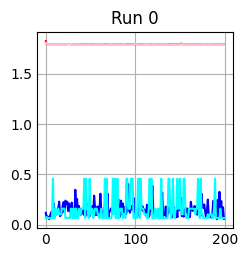

In [41]:
indxs = get_k_indx(k, len(ys))

for i in range(1):
    train_indx, val_indx, test_indx  = indxs[i]
    xs_meta_i = xs_meta[train_indx]
    xs_meta_i_val = xs_meta[val_indx]
    xs_meta_i_test = xs_meta[test_indx]
    
    xs_global_i = xs_global[train_indx]
    xs_global_i_val = xs_global[val_indx]
    xs_global_i_test = xs_global[test_indx]
    
    xs_frontal_i = xs_frontal[train_indx]
    xs_frontal_i_val = xs_frontal[val_indx]
    xs_frontal_i_test = xs_frontal[test_indx]
    
    xs_oral_i = xs_oral[train_indx]
    xs_oral_i_val = xs_oral[val_indx]
    xs_oral_i_test = xs_oral[test_indx]
    
    xs_orbital_i = xs_orbital[train_indx]
    xs_orbital_i_val = xs_orbital[val_indx]
    xs_orbital_i_test = xs_orbital[test_indx]
    
    ys_i = ys[train_indx]
    ys_i_val = ys[val_indx]
    ys_i_test = ys[test_indx]

    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(ys_i),
                                                 y=ys_i)
    weight_training_classes = {}
    for indx, value in enumerate(class_weights):
        weight_training_classes[indx] = value

        
    model = get_model()

    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20)
    ]
    
    hist = model.fit(
        x=[
            xs_meta_i, 
            xs_global_i, 
            xs_frontal_i,
            xs_oral_i,
            xs_orbital_i], y=ys_i, 
        validation_data=([
            xs_meta_i_val,
            xs_global_i_val,
            xs_frontal_i_val,
            xs_oral_i_val,
            xs_orbital_i_val], ys_i_val),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        #callbacks=model_callbacks,
        verbose=VERBOSE)
    
    
    # visualizing losses and accuracy
    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_acc  = hist.history['accuracy']
    val_acc    = hist.history['val_accuracy']
    xc         = range(len(hist.history['loss']))    
    
    plt.figure()
    plt.title(f'Run {i}')
    plt.plot(xc, train_loss, color='red')
    plt.plot(xc, val_loss, color='pink')
    plt.plot(xc, train_acc, color='blue')
    plt.plot(xc, val_acc, color='cyan')
    
    y_pred = model.predict([
        xs_meta_i_test,
        xs_global_i_test,
        xs_frontal_i_test,
        xs_oral_i_test,
        xs_orbital_i_test],verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)

    print(classification_report(ys_i_test, y_pred_bool))

# Model Serialization 

In [ ]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type2-with-fe')

In [ ]:
model.save(dir_model)